# **Implementing Transformers for Text Generation**


In [38]:
import tensorflow as tf 
import pandas as pd
import numpy as np
from tensorflow.keras.layers import TextVectorization 
from tensorflow.keras.utils import get_file 

In [40]:
csv_path = '/kaggle/input/dataset/output_sentences.csv'  # Replace with your actual CSV file path
data = pd.read_csv(csv_path)

In [42]:
text = data['Sentence'].tolist()
print("Preview of dataset:", text[:2])  # Preview first 5 sentences

Preview of dataset: ['-about-us-container">About P@SHA Chairman’s Message Association Details Central Executive Committee Sub Committees Secretariat Partners Elections 2024 Careers Action Another action Submenu --> Elections 2023 --> Members --> Membership Benefits Discounts Hotels Apply Membership Form Renew Membership Members Directory Publications --> Industry Engagement Skills Development P@SHA Governance Policy Advocacy Industry Overview Animation Gaming Media --> P@SHA Pulse P@SHA Connect P@SHA Candid Press Releases Featured Articles News Picture Gallery Events --> Global National Contact Join P@SHA Search for: --> About P@SHA Chairman’s Message Association Details Central Executive Committee Sub Committees Secretariat Partners Elections 2024 Careers About Us Membership Benefits Discounts Hotels Apply Membership Form Renew Membership Members Directory Members Industry Engagement Skills Development P@SHA Governance Policy Advocacy Industry Overview Animation Gaming Publications P@

# Preprocessing

In [43]:
# Preprocess the dataset
vocab_size = 1000
seq_length = 10

# Adapt TextVectorization to the full text
vectorizer = TextVectorization(max_tokens=vocab_size, output_mode='int')

# Create a TensorFlow dataset from the text data
text_ds = tf.data.Dataset.from_tensor_slices(text).batch(1)

# Adapt the vectorizer to the dataset
vectorizer.adapt(text_ds)

# Vectorize the text (example for one sentence)
vectorized_text = vectorizer([text[0]])[0]  # Vectorizing the first sentence
print("Vectorized text shape:", vectorized_text.shape)
print("First 10 vectorized tokens:", vectorized_text.numpy()[:10])

Vectorized text shape: (262,)
First 10 vectorized tokens: [ 1  4 59 54 24 40 42 29 44 47]


In [45]:
def create_sequences(text, seq_length): 
    input_seqs = [] 
    target_seqs = [] 
    for i in range(len(text) - seq_length): 
        input_seq = text[i:i + seq_length] 
        target_seq = text[i + 1:i + seq_length + 1] 
        input_seqs.append(input_seq) 
        target_seqs.append(target_seq) 
    return np.array(input_seqs), np.array(target_seqs) 

# Generate sequences 
X, Y = create_sequences(vectorized_text.numpy(), seq_length) 

# Check if sequences are correctly generated 
print("Number of sequences generated:", len(X)) 
print("Sample input sequence:", X[0] if len(X) > 0 else "No sequences generated") 

# Check if X and Y are not empty 
assert X.size > 0, "Input data X is empty" 
assert Y.size > 0, "Target data Y is empty" 
X = tf.convert_to_tensor(X) 
Y = tf.convert_to_tensor(Y) 
print("Shape of X:", X.shape) 
print("Shape of Y:", Y.shape)


Number of sequences generated: 252
Sample input sequence: [ 1  4 59 54 24 40 42 29 44 47]
Shape of X: (252, 10)
Shape of Y: (252, 10)


# Model Intialization

In [49]:
from tensorflow.keras.layers import Input, Embedding, Dropout, Dense, LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, seq_length, embed_dim):
        super(PositionalEncoding, self).__init__()
        self.positional_encoding = self.get_positional_encoding(seq_length, embed_dim)

    def get_positional_encoding(self, seq_length, embed_dim):
        positions = tf.range(seq_length, dtype=tf.float32)[:, tf.newaxis]
        indices = tf.range(embed_dim, dtype=tf.float32)[tf.newaxis, :]
        angle_rates = 1 / tf.pow(10000.0, (2 * (indices // 2)) / tf.cast(embed_dim, tf.float32))
        angle_rads = positions * angle_rates

        # Apply sine to even indices (0, 2, 4, ...) and cosine to odd indices (1, 3, 5, ...)
        sin_terms = tf.sin(angle_rads[:, 0::2])
        cos_terms = tf.cos(angle_rads[:, 1::2])

        # Combine sine and cosine terms into a single tensor
        pos_encoding = tf.concat([sin_terms, cos_terms], axis=-1)
        return pos_encoding[tf.newaxis, ...]

    def call(self, inputs):
        return inputs + self.positional_encoding[:, :tf.shape(inputs)[1], :]


# Transformer block
def transformer_block(x, embed_dim, num_heads, ff_dim, dropout_rate):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
    attn_output = Dropout(dropout_rate)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(x + attn_output)

    ffn_output = Dense(ff_dim, activation="relu")(out1)
    ffn_output = Dense(embed_dim)(ffn_output)
    ffn_output = Dropout(dropout_rate)(ffn_output)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

    return out2

from tensorflow.keras.layers import Lambda

# Build the model
def build_small_transformer_model(vocab_size, seq_length, embed_dim=128, num_heads=2, ff_dim=256, num_layers=2, dropout_rate=0.1):
    inputs = Input(shape=(seq_length,))
    embedding_layer = Embedding(vocab_size, embed_dim)(inputs)
    positional_encoded = PositionalEncoding(seq_length, embed_dim)(embedding_layer)

    x = positional_encoded
    for _ in range(num_layers):
        x = transformer_block(x, embed_dim, num_heads, ff_dim, dropout_rate)

    outputs = Dense(vocab_size, activation="softmax")(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Hyperparameters
embed_dim = 128 
num_heads = 2 
ff_dim = 128 
num_layers = 2 
dropout_rate = 0.1




# Build the model
small_transformer_model = build_small_transformer_model(
    vocab_size, seq_length, embed_dim, num_heads, ff_dim, num_layers, dropout_rate
)

# Compile the model
small_transformer_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Summary
small_transformer_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 10, 128)   │    128,000 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, 10, 128)   │          0 │ embedding_3[0][0] │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 128)   │    131,968 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 10, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 10, 128)   │          0 │ positional_encod… │
│                     │                   │            │ dropout_19[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 128)   │        256 │ add_12[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 10, 128)   │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 10, 128)   │     16,512 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 10, 128)   │          0 │ dense_16[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 10, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_20[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 128)   │        256 │ add_13[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 128)   │    131,968 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 10, 128)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_14 (Add)        │ (None, 10, 128)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_22[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 128)   │        256 │ add_14[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 10, 128)   │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 10, 128)   │     16,512 │ dense_17[0][0]  

 Total params: 588,008 (2.24 MB)

 Trainable params: 588,008 (2.24 MB)

 Non-trainable params: 0 (0.00 B)

# Splitting into Training and validation dataset

In [50]:
from sklearn.model_selection import train_test_split

# Convert TensorFlow tensors to NumPy arrays
X_np = X.numpy()
Y_np = Y.numpy()

# Split the data
X_train, X_val, Y_train, Y_val = train_test_split(X_np, Y_np, test_size=0.2, random_state=42)

# Check the shape of splits
print("Training data shape:", X_train.shape, Y_train.shape)
print("Validation data shape:", X_val.shape, Y_val.shape)

# Convert back to TensorFlow tensors if needed
X_train = tf.convert_to_tensor(X_train)
Y_train = tf.convert_to_tensor(Y_train)
X_val = tf.convert_to_tensor(X_val)
Y_val = tf.convert_to_tensor(Y_val)


Training data shape: (201, 10) (201, 10)
Validation data shape: (51, 10) (51, 10)


Epoch 1/20


W0000 00:00:1735994129.786112     110 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


1/7 ━━━━━━━━━━━━━━━━━━━━ 1:09 12s/step - accuracy: 0.0000e+00 - loss: 6.9937

W0000 00:00:1735994136.839954     111 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0304 - loss: 6.6083       

W0000 00:00:1735994143.568622     112 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1735994144.221201     111 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.0323 - loss: 6.5751 - val_accuracy: 0.0647 - val_loss: 5.5547
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0622 - loss: 5.3894 - val_accuracy: 0.0647 - val_loss: 4.8065
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0646 - loss: 4.7449 - val_accuracy: 0.0647 - val_loss: 4.4929
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0613 - loss: 4.4781 - val_accuracy: 0.0647 - val_loss: 4.3724
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0571 - loss: 4.3977 - val_accuracy: 0.0647 - val_loss: 4.2913
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0644 - loss: 4.2981 - val_accuracy: 0.0824 - val_loss: 4.0758
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1030 - loss: 4.0527 - val_accuracy: 0.0824 - val_loss: 3.8092
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1906 - loss: 3.7651 - val_accuracy: 0.3000 - val_loss: 3.2434
Epoch 9/20
7/7 ━━━

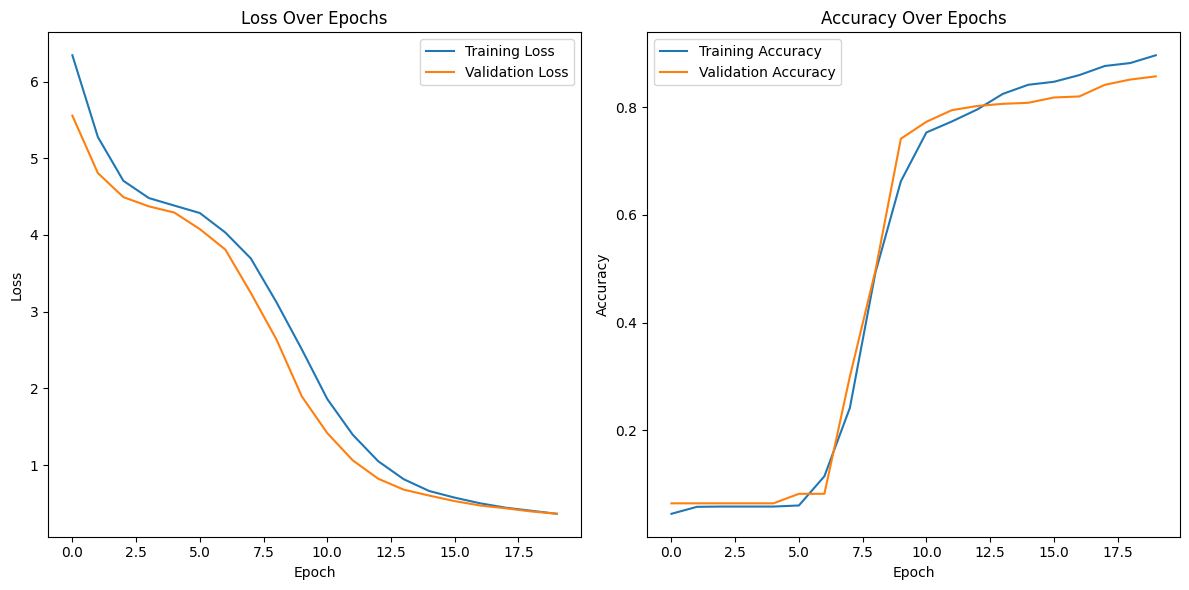

In [51]:
# Import necessary libraries for training visualization
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping callback to stop training if the loss doesn't improve
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Train the transformer model
history = small_transformer_model.fit(
    X_train, 
    Y_train, 
    validation_data=(X_val, Y_val),  # Provide validation data
    epochs=20, 
    batch_size=32, 
    callbacks=[early_stopping]
)

import matplotlib.pyplot as plt

# Extract accuracy and loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


In [53]:
def generate_text(model, start_string, vectorizer, seq_length, num_generate=10, temperature=1.0):
    """
    Generate text using the trained transformer model.

    Args:
        model: The trained small transformer model.
        start_string: The initial string to seed the text generation.
        vectorizer: The TextVectorization layer used for tokenizing input.
        seq_length: The expected input sequence length for the model.
        num_generate: The number of tokens to generate.
        temperature: Controls randomness in prediction; lower values = more deterministic output.

    Returns:
        A string containing the generated text.
    """
    import numpy as np
    import tensorflow as tf

    # Vectorize the start string
    input_eval = vectorizer([start_string]).numpy()

    # Ensure the input matches the required sequence length
    if input_eval.shape[1] < seq_length:
        padding = np.zeros((1, seq_length - input_eval.shape[1]))
        input_eval = np.concatenate((padding, input_eval), axis=1)
    elif input_eval.shape[1] > seq_length:
        input_eval = input_eval[:, -seq_length:]

    # Convert to TensorFlow tensor
    input_eval = tf.convert_to_tensor(input_eval, dtype=tf.int32)

    # Initialize list to store the generated text
    text_generated = []
    vocab = vectorizer.get_vocabulary()
    vocab_size = len(vocab)

    # Start generating text
    for _ in range(num_generate):
        # Get predictions from the model
        predictions = model(input_eval, training=False)

        # Use the logits from the last position in the sequence
        predictions = predictions[:, -1, :]  # Shape: (batch_size, vocab_size)

        # Clamp predictions to vocabulary size
        predictions = predictions[:, :vocab_size]

        # Apply temperature to control randomness
        predictions = predictions / temperature

        # Sample the next token from the probability distribution
        predicted_id = tf.random.categorical(predictions, num_samples=1)[0, 0].numpy()

        # Check for valid token ID
        if predicted_id < vocab_size:
            text_generated.append(vocab[predicted_id])
        else:
            text_generated.append("<UNK>")  # Handle out-of-range IDs

        # Update input to include the predicted token
        input_eval = np.append(input_eval.numpy(), [[predicted_id]], axis=1)
        input_eval = input_eval[:, -seq_length:]  # Ensure the sequence length is maintained
        input_eval = tf.convert_to_tensor(input_eval, dtype=tf.int32)

    # Combine the generated tokens with the start string
    return start_string + ' ' + ' '.join(text_generated)



In [54]:
# Generate text with your small_transformer_model
start_string = "The Higher education commission is"
generated_text = generate_text(
    model=small_transformer_model,
    start_string=start_string,
    vectorizer=vectorizer,
    seq_length=seq_length,
    num_generate=5,
    temperature=0.4  # Adjust temperature for randomness
)
print(generated_text)


The Higher education commission is individual omni market delivering young


# **Code with Word2Vec**

In [33]:
import tensorflow as tf 
import pandas as pd
import numpy as np
from tensorflow.keras.layers import TextVectorization 
from tensorflow.keras.utils import get_file 

csv_path = '/kaggle/input/dataset/output_sentences.csv'  # Replace with your actual CSV file path
data = pd.read_csv(csv_path)

text = data['Sentence'].tolist()
print("Preview of dataset:", text[:2])  # Preview first 5 sentences

Preview of dataset: ['-about-us-container">About P@SHA Chairman’s Message Association Details Central Executive Committee Sub Committees Secretariat Partners Elections 2024 Careers Action Another action Submenu --> Elections 2023 --> Members --> Membership Benefits Discounts Hotels Apply Membership Form Renew Membership Members Directory Publications --> Industry Engagement Skills Development P@SHA Governance Policy Advocacy Industry Overview Animation Gaming Media --> P@SHA Pulse P@SHA Connect P@SHA Candid Press Releases Featured Articles News Picture Gallery Events --> Global National Contact Join P@SHA Search for: --> About P@SHA Chairman’s Message Association Details Central Executive Committee Sub Committees Secretariat Partners Elections 2024 Careers About Us Membership Benefits Discounts Hotels Apply Membership Form Renew Membership Members Directory Members Industry Engagement Skills Development P@SHA Governance Policy Advocacy Industry Overview Animation Gaming Publications P@

In [34]:
import numpy as np

# Path to GloVe file
glove_path = '/kaggle/input/glove-embedings/glove.6B.200d.txt'  # Update this path with the location of your GloVe file
embedding_dim = 200  # Use the dimension of the GloVe embeddings you're loading (50, 100, 200, or 300)

# Load the GloVe embeddings into a dictionary
embeddings_index = {}
with open(glove_path, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f"Loaded {len(embeddings_index)} word vectors.")


Loaded 400000 word vectors.


In [35]:
# Preprocess the dataset
vocab_size = 1000
seq_length = 50

# Adapt TextVectorization to the full text
vectorizer = TextVectorization(max_tokens=vocab_size, output_mode='int')

# Create a TensorFlow dataset from the text data
text_ds = tf.data.Dataset.from_tensor_slices(text).batch(1)

# Adapt the vectorizer to the dataset
vectorizer.adapt(text_ds)

# Vectorize the text (example for one sentence)
vectorized_text = vectorizer([text[0]])[0]  # Vectorizing the first sentence
print("Vectorized text shape:", vectorized_text.shape)
print("First 10 vectorized tokens:", vectorized_text.numpy()[:10])

Vectorized text shape: (262,)
First 10 vectorized tokens: [ 1  4 59 54 24 40 42 29 44 47]


In [36]:
def create_sequences(text, seq_length): 
    input_seqs = [] 
    target_seqs = [] 
    for i in range(len(text) - seq_length): 
        input_seq = text[i:i + seq_length] 
        target_seq = text[i + 1:i + seq_length + 1] 
        input_seqs.append(input_seq) 
        target_seqs.append(target_seq) 
    return np.array(input_seqs), np.array(target_seqs) 

# Generate sequences 
X, Y = create_sequences(vectorized_text.numpy(), seq_length) 

# Check if sequences are correctly generated 
print("Number of sequences generated:", len(X)) 
print("Sample input sequence:", X[0] if len(X) > 0 else "No sequences generated") 

# Check if X and Y are not empty 
assert X.size > 0, "Input data X is empty" 
assert Y.size > 0, "Target data Y is empty" 
X = tf.convert_to_tensor(X) 
Y = tf.convert_to_tensor(Y) 
print("Shape of X:", X.shape) 
print("Shape of Y:", Y.shape)


Number of sequences generated: 212
Sample input sequence: [  1   4  59  54  24  40  42  29  44  47  41  23  32  17  19  45  81 118
  81 142  17 121  16   9  36  57  55  46   9  77  48   9  16  58  37  11
  27  34  21   4  33  35  63  11  53  62  43  31   4  50]
Shape of X: (212, 50)
Shape of Y: (212, 50)


In [37]:
# Build the embedding matrix
vocab = vectorizer.get_vocabulary()
vocab_size = len(vocab)
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for i, word in enumerate(vocab):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        # Words not found in the pre-trained embeddings will be all zeros
        embedding_matrix[i] = np.zeros(embedding_dim)

# Create the embedding layer with pre-trained weights
embedding_layer = tf.keras.layers.Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=seq_length,
    trainable=False  # Set to True to fine-tune the embeddings during training
)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [59]:
from tensorflow.keras.layers import Input, Embedding, Dropout, Dense, LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, seq_length, embed_dim):
        super(PositionalEncoding, self).__init__()
        self.positional_encoding = self.get_positional_encoding(seq_length, embed_dim)

    def get_positional_encoding(self, seq_length, embed_dim):
        positions = tf.range(seq_length, dtype=tf.float32)[:, tf.newaxis]
        indices = tf.range(embed_dim, dtype=tf.float32)[tf.newaxis, :]
        angle_rates = 1 / tf.pow(10000.0, (2 * (indices // 2)) / tf.cast(embed_dim, tf.float32))
        angle_rads = positions * angle_rates

        # Apply sine to even indices (0, 2, 4, ...) and cosine to odd indices (1, 3, 5, ...)
        sin_terms = tf.sin(angle_rads[:, 0::2])
        cos_terms = tf.cos(angle_rads[:, 1::2])

        # Combine sine and cosine terms into a single tensor
        pos_encoding = tf.concat([sin_terms, cos_terms], axis=-1)
        return pos_encoding[tf.newaxis, ...]

    def call(self, inputs):
        return inputs + self.positional_encoding[:, :tf.shape(inputs)[1], :]


# Transformer block
def transformer_block(x, embed_dim, num_heads, ff_dim, dropout_rate):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
    attn_output = Dropout(dropout_rate)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(x + attn_output)

    ffn_output = Dense(ff_dim, activation="relu")(out1)
    ffn_output = Dense(embed_dim)(ffn_output)
    ffn_output = Dropout(dropout_rate)(ffn_output)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

    return out2

from tensorflow.keras.layers import Lambda

# Build the model
def build_transformer_with_pretrained_embeddings(seq_length, embed_dim, num_heads, ff_dim, num_layers, dropout_rate):
    inputs = Input(shape=(seq_length,))
    x = embedding_layer(inputs)  # Use pre-trained embedding layer
    positional_encoded = PositionalEncoding(seq_length, embed_dim)(x)

    for _ in range(num_layers):
        x = transformer_block(x, embed_dim, num_heads, ff_dim, dropout_rate)

    outputs = Dense(vocab_size, activation="softmax")(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Hyperparameters
embed_dim = 128 
num_heads = 4 
ff_dim = 128 
num_layers = 4 
dropout_rate = 0.01




# Build the model
transformer_model = build_transformer_with_pretrained_embeddings(
    seq_length=seq_length,
    embed_dim=embedding_dim,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_layers=num_layers,
    dropout_rate=dropout_rate
)

# Compile the model
transformer_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Summary
transformer_model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 10, 200)   │    200,000 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 200)   │    642,600 │ embedding_2[0][0… │
│ (MultiHeadAttentio… │                   │            │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 10, 200)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 10, 200)   │          0 │ embedding_2[0][0… │
│                     │                   │            │ dropout_25[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 200)   │        400 │ add_16[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 10, 128)   │     25,728 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 10, 200)   │     25,800 │ dense_20[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 10, 200)   │          0 │ dense_21[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 10, 200)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_26[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 200)   │        400 │ add_17[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 200)   │    642,600 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 10, 200)   │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 10, 200)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_28[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 200)   │        400 │ add_18[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 10, 128)   │     25,728 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 10, 200)   │     25,800 │ dense_22[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 10, 200)   │          0 │ dense_23[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 3,180,712 (12.13 MB)

 Trainable params: 2,980,712 (11.37 MB)

 Non-trainable params: 200,000 (781.25 KB)

In [55]:
from sklearn.model_selection import train_test_split

# Convert TensorFlow tensors to NumPy arrays
X_np = X.numpy()
Y_np = Y.numpy()

# Split the data
X_train, X_val, Y_train, Y_val = train_test_split(X_np, Y_np, test_size=0.2, random_state=42)

# Check the shape of splits
print("Training data shape:", X_train.shape, Y_train.shape)
print("Validation data shape:", X_val.shape, Y_val.shape)

# Convert back to TensorFlow tensors if needed
X_train = tf.convert_to_tensor(X_train)
Y_train = tf.convert_to_tensor(Y_train)
X_val = tf.convert_to_tensor(X_val)
Y_val = tf.convert_to_tensor(Y_val)


Training data shape: (201, 10) (201, 10)
Validation data shape: (51, 10) (51, 10)


# Training

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.0621 - loss: 6.2189 - val_accuracy: 0.4451 - val_loss: 4.0969
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5153 - loss: 3.7242 - val_accuracy: 0.7275 - val_loss: 2.3265
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7459 - loss: 2.0967 - val_accuracy: 0.8196 - val_loss: 1.2651
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8206 - loss: 1.1378 - val_accuracy: 0.8686 - val_loss: 0.6935
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8654 - loss: 0.6809 - val_accuracy: 0.8882 - val_loss: 0.4304
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8905 - loss: 0.4198 - val_accuracy: 0.9157 - val_loss: 0.3088
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9120 - loss: 0.3064 - val_accuracy: 0.9137 - val_loss: 0.2645
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9248 - loss: 0.2428 - val_accuracy: 0.9137 - val_loss: 0.2223
E

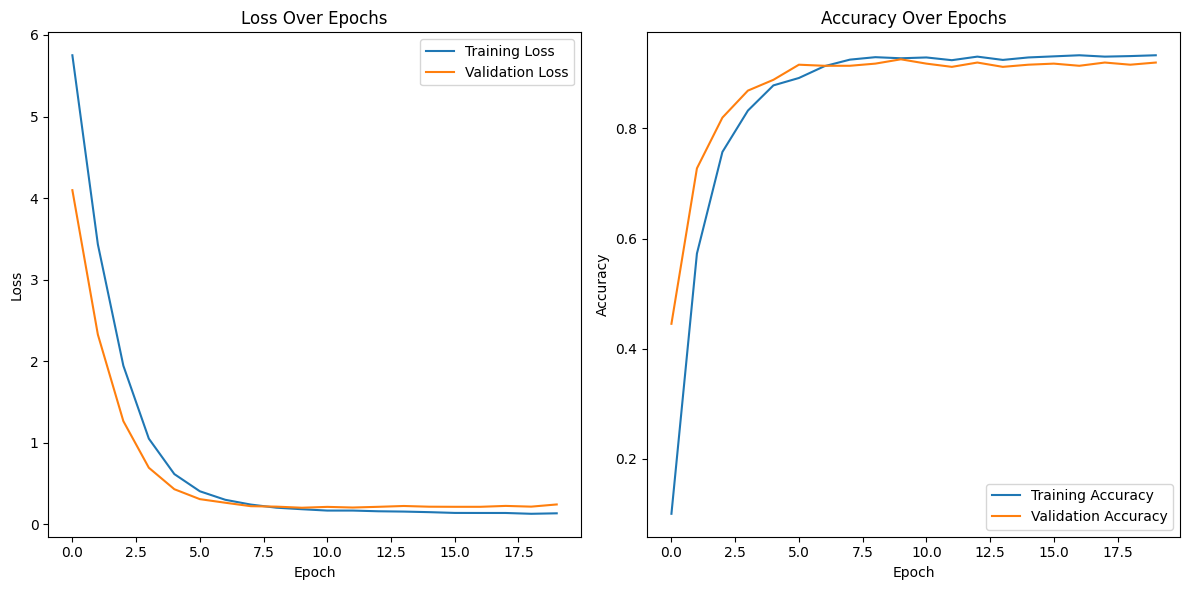

In [60]:
# Import necessary libraries for training visualization
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping callback to stop training if the loss doesn't improve
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Train the transformer model
history = transformer_model.fit(
    X_train, 
    Y_train, 
    validation_data=(X_val, Y_val),  # Provide validation data
    epochs=20, 
    batch_size=32, 
    callbacks=[early_stopping]
)

import matplotlib.pyplot as plt

# Extract accuracy and loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


In [61]:
def generate_text(model, start_string, vectorizer, seq_length, num_generate=10, temperature=1.0):
    """
    Generate text using the trained transformer model.

    Args:
        model: The trained small transformer model.
        start_string: The initial string to seed the text generation.
        vectorizer: The TextVectorization layer used for tokenizing input.
        seq_length: The expected input sequence length for the model.
        num_generate: The number of tokens to generate.
        temperature: Controls randomness in prediction; lower values = more deterministic output.

    Returns:
        A string containing the generated text.
    """
    import numpy as np
    import tensorflow as tf

    # Vectorize the start string
    input_eval = vectorizer([start_string]).numpy()

    # Ensure the input matches the required sequence length
    if input_eval.shape[1] < seq_length:
        padding = np.zeros((1, seq_length - input_eval.shape[1]))
        input_eval = np.concatenate((padding, input_eval), axis=1)
    elif input_eval.shape[1] > seq_length:
        input_eval = input_eval[:, -seq_length:]

    # Convert to TensorFlow tensor
    input_eval = tf.convert_to_tensor(input_eval, dtype=tf.int32)

    # Initialize list to store the generated text
    text_generated = []
    vocab = vectorizer.get_vocabulary()
    vocab_size = len(vocab)

    # Start generating text
    for _ in range(num_generate):
        # Get predictions from the model
        predictions = model(input_eval, training=False)

        # Use the logits from the last position in the sequence
        predictions = predictions[:, -1, :]  # Shape: (batch_size, vocab_size)

        # Clamp predictions to vocabulary size
        predictions = predictions[:, :vocab_size]

        # Apply temperature to control randomness
        predictions = predictions / temperature

        # Sample the next token from the probability distribution
        predicted_id = tf.random.categorical(predictions, num_samples=1)[0, 0].numpy()

        # Check for valid token ID
        if predicted_id < vocab_size:
            text_generated.append(vocab[predicted_id])
        else:
            text_generated.append("<UNK>")  # Handle out-of-range IDs

        # Update input to include the predicted token
        input_eval = np.append(input_eval.numpy(), [[predicted_id]], axis=1)
        input_eval = input_eval[:, -seq_length:]  # Ensure the sequence length is maintained
        input_eval = tf.convert_to_tensor(input_eval, dtype=tf.int32)

    # Combine the generated tokens with the start string
    return start_string + ' ' + ' '.join(text_generated)



## Text generation

In [62]:
# Generate text with your small_transformer_model
start_string = "The Higher education commission"
generated_text = generate_text(
    model=transformer_model,
    start_string=start_string,
    vectorizer=vectorizer,
    seq_length=seq_length,
    num_generate=5,
    temperature=0.7  # Adjust temperature for randomness
)
print(generated_text)


The Higher education commission con 2024 explore work home
